In [1]:
import pandas as pd
import random
import torch, torchtext
from torchtext import data
import spacy
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import string 
punctuations = list(string.punctuation)
punctuations.append("''")

def preprocess(sentence):
    text_tokens = word_tokenize(sentence)
    tokens_filtered = [i.strip("".join(punctuations)) for i in text_tokens if i not in punctuations]
    tokens_filtered = (" ").join(tokens_filtered)
    #text_tokens = word_tokenize(tokens_filtered)
    #tokens_filtered= [word for word in text_tokens if not word in STOPWORDS]
    return tokens_filtered

In [3]:
def convert_values(float_number):
    if 0 <= float_number <=0.2 :
        return 0
    if 0.2 < float_number <=0.4 :
        return 1
    if 0.4 <float_number <=0.6 :
        return 2
    if 0.6 <float_number <=0.8 :
        return 3
    if 0.8 <float_number <=1 :
        return 4

In [4]:
import pandas as pd
import numpy as np
  
# reading two csv files
# reading two csv files
data_sentence = pd.read_csv('datasets/datasetSentences.txt',sep='\t')
data_split = pd.read_csv('datasets/datasetSplit.txt')
dictionary = pd.read_csv('datasets/dictionary.txt',sep='|')
sentiment_labels = pd.read_csv('datasets/sentiment_labels.txt',sep='|')

# Merging the "datasetSentences.txt" and "datasetSplit.txt" based on sentence_index
data_sent_split = pd.merge(data_sentence,data_split,how='inner',on='sentence_index')

#Merging data_sent_split with dictinary based on the phrase
comp_data = data_sent_split.merge(dictionary, left_on='sentence', right_on='phrase')  

# Merging comp_data and sentiment labels based on phrase_id
sst_dataset = comp_data.merge(sentiment_labels,left_on='phrase_id', right_on='phrase ids')

# Converting the floating point sentiment values to 5 Class labels
sst_dataset['new_label'] = sst_dataset['sentiment values'].apply(convert_values)

# Dropping the unwanted columns fron the dataframe
sst_dataset.drop(['phrase ids','phrase','sentence_index','phrase_id','splitset_label','sentiment values'],axis=1,inplace=True)

sst_dataset.to_csv( "datasets/sst_dataset.csv", index=False, encoding='utf-8-sig')



In [5]:
df = pd.read_csv('datasets/sst_dataset.csv')
df.head(10)

,sentence,new_label
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Effective but too-tepid biopic,2
3,If you sometimes like to go to the movies to h...,3
4,"Emerges as something rare , an issue movie tha...",4
5,The film provides some great insight into the ...,2
6,Offers that rare combination of entertainment ...,4
7,Perhaps no picture ever made has more literall...,3
8,Steers turns in a snappy screenplay that curls...,3
9,But he somehow pulls it off .,3


In [6]:
for i in df.index:
    x = preprocess(df.sentence[i])
    if len(x) == 0:
        df.at[i, "sentence"] = df.sentence[i]
    else:
        df.at[i, "sentence"] = x

In [7]:
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
Sentence = torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [10]:
fields = [('sentence', Sentence), ('new_label', Label)]

In [11]:
example = [torchtext.legacy.data.Example.fromlist([df.sentence[i],df.new_label[i]], fields) for i in range(df.shape[0])] 

In [12]:

stanford_dataset = torchtext.legacy.data.Dataset(example, fields)

In [13]:
(train, test) = stanford_dataset.split(split_ratio=[0.70, 0.30], random_state=random.seed(SEED))

In [14]:
len(train), len(test)

(7900, 3386)

In [15]:
vars(stanford_dataset.examples[278])

{'new_label': 1,
 'sentence': ['Has',
  'it',
  'ever',
  'been',
  'possible',
  'to',
  'say',
  'that',
  'Williams',
  'has',
  'truly',
  'inhabited',
  'a',
  'character']}

In [16]:
Sentence.build_vocab(stanford_dataset)
Label.build_vocab(stanford_dataset)

In [17]:
print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  19422
Size of label vocab :  5
Top 10 words appreared repeatedly : [('the', 7968), ('and', 5778), ('of', 5775), ('a', 5762), ('to', 4000), ('-', 3437), ('is', 3343), ('s', 3293), ('that', 2468), ('in', 2395)]
Labels :  defaultdict(None, {1: 0, 3: 1, 2: 2, 4: 3, 0: 4})


In [18]:

train_iterator, valid_iterator = torchtext.legacy.data.BucketIterator.splits((train, test), batch_size = 32, 
                                                            sort_key = lambda x: len(x.sentence),
                                                            sort_within_batch=True, device = device)

In [19]:
next(iter(train_iterator))



[torchtext.legacy.data.batch.Batch of size 32]
	[.sentence]:('[torch.cuda.LongTensor of size 32x9 (GPU 0)]', '[torch.cuda.LongTensor of size 32 (GPU 0)]')
	[.new_label]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [20]:
import os, pickle
with open('tokenizer/tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Sentence.vocab.stoi, tokens)

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,                           
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        #self.fc1 = nn.Linear(hidden_dim, hidden_fcn) #one more fully connected layer

        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        hidden = self.dropout(hidden)  
        
        #one more Fully connected layer
        dense_outputs = self.fc2(hidden)

        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [22]:
# Define hyperparameters
size_of_vocab = len(Sentence.vocab)
embedding_dim = 300
num_hidden_nodes = 50
num_output_nodes = 5
num_layers = 2
dropout = 0.3

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [23]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(19422, 300)
  (encoder): LSTM(300, 50, num_layers=2, batch_first=True, dropout=0.3)
  (fc2): Linear(in_features=50, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
The model has 5,917,655 trainable parameters


In [24]:
import torch.optim as optim
#CUDA_LAUNCH_BLOCKING=1
# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [25]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.sentence  
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.new_label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.new_label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.new_label)
            acc = binary_accuracy(predictions, batch.new_label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 50
best_valid_loss = float('inf')
train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []
for epoch in range(N_EPOCHS):
     
    # train the model
    print("Epoch:",epoch,flush=True)
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # evaluate the model    
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'weights/saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',flush=True)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n',flush=True)

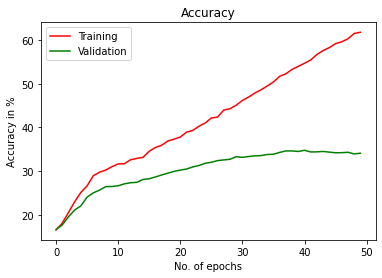

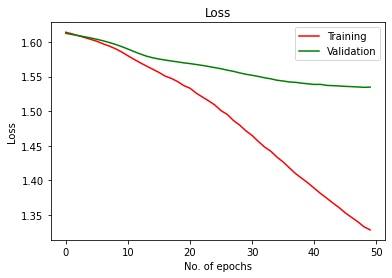

In [29]:
import matplotlib
from matplotlib import pyplot as plt

epoch = range(N_EPOCHS)
plt.plot(epoch, [x*100 for x in train_acc_list],linestyle='solid', color='r', label='Training')
plt.plot(epoch, [x*100 for x in valid_acc_list],linestyle='solid', color='g', label='Validation')
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy in %')
#plt.ylim(40,100)
plt.title("Accuracy",loc='center')
plt.legend()
plt.show()


epoch = range(N_EPOCHS)
plt.plot(epoch, train_loss_list,linestyle='solid',color='r', label='Training')
plt.plot(epoch, valid_loss_list,linestyle='solid', color='g', label='Validation')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
#plt.ylim(0.5,1.5)
plt.title("Loss",loc='center')
plt.legend()
plt.show()

In [30]:
path='weights/saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('tokenizer/tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en_core_web_sm')

def classify_review(review):
    
    categories = {0: "Very Negative", 1:"Negative", 2:"Neutral",3: "Positive", 4:" Very Positive",}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(review)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]